# Optimize input to maximize growth

Here we attempt to find the best combination of input values to optimize the growth rate of the model. As the model is trained on experimental data, it should represent the behavior of the chassis and the compounds should optimize growth. (We can use the same model with KO and optimize also the choice of gene KO.)

### Load the data, build and train the AMNWt model

In [45]:
import tensorflow as tf
from amn.model import AMNWtModel

data_dir = "../data"
seed = 10
# np.random.seed(seed=seed)  
tf.random.set_seed(seed)

dataset_file = "/Dataset/iML1515_EXP_UB.npz"
objective = ["BIOMASS_Ec_iML1515_core_75p37M"]
epochs = 700
batch_size = 7
uptake_max_index=None

model = AMNWtModel(dataset_file=data_dir + dataset_file, 
                   objective=objective,
                   timestep=4,
                   hidden_dim=50,
                   verbose=True,
                   uptake_max_index = uptake_max_index)
model.printout()

# Preprocessing
from amn.tools import MaxScaler
scaler= MaxScaler()
model.train_test_split(test_size=0.1, random_state=seed)
model.preprocess(scaler)
model.preprocessing_for_specific_model()


AMNWt_model = model.build_model()
history = AMNWt_model.fit(model.X_train, model.Y_train, epochs=epochs, batch_size=batch_size, verbose=0)

print("R2 :", model.R2(model.Y_train, AMNWt_model.predict(model.X_train)))
print("Q2 :", model.R2(model.Y_test, AMNWt_model.predict(model.X_test)))

---------------------------------------- model ----------------------------------------
number of metabolites:  1080
filtered measurements size:  1
dataset file: ../data/Dataset/iML1515_EXP_UB.npz
model type: AMNWt
model medium bound: UB
timestep: 4
training set size (110, 38) (110, 1)
nbr hidden layer: 1
hidden layer size: 50
activation function: relu
R2 : 0.8396070541180849
Q2 : 0.7075770958024504


Gradient descent on a toy function

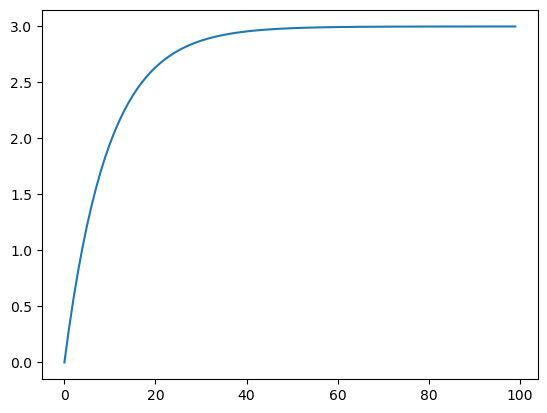

In [158]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

opt = tf.keras.optimizers.SGD(learning_rate=0.1)
n_iter = 100

X = 0
var = tf.Variable(X, dtype=tf.float32)
G = []
Y = [var.numpy()]

for i in range(n_iter):
    old_var = var.numpy()
    loss = lambda : (var-3)**2/2.0
    # loss = lambda : (var**2/2, (var-3)**2/2.0) ## in case of several dimension of the loss the optimize function optimize the sum
    opt.minimize(loss, [var])
    new_var = var.numpy()
    G.append(old_var - new_var)
    Y.append(new_var)


x = np.arange(0, n_iter)
fig, ax = plt.subplots()
ax.plot(x, Y[:n_iter])

### Gradient descent on AMNWt optimizing growth rate

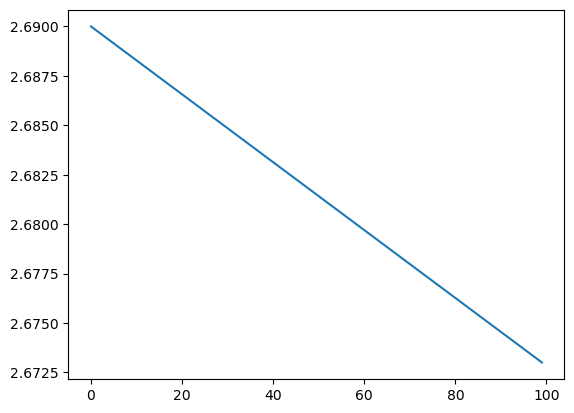

In [160]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

opt = tf.keras.optimizers.SGD(learning_rate=0.1)
n_iter = 100

Pout = tf.convert_to_tensor(np.float32(model.P_out)) 
X = model.X_test[4] + 1.69 * model.X_test[0]**2
var = tf.Variable(X.reshape(1,38), dtype=tf.float32)
G = []
Y = [var.numpy()]

for i in range(n_iter):
    old_var = var.numpy()
    loss = lambda : - tf.linalg.matmul(AMNWt_model(var)[:,:model.S.shape[1]], tf.transpose(Pout))
    opt.minimize(loss, [var])
    new_var = var.numpy()
    G.append(old_var - new_var)
    Y.append(new_var)


G = np.array(G)
Y = np.array(Y)

# between 0 and 37
n_feature = 16
x = np.arange(0, n_iter)
fig, ax = plt.subplots()
ax.plot(x, Y[:,:,n_feature][:n_iter])

The gradient is constant for growth rate !

In [142]:
for n_feature in range(38):    
    is_constant = np.all(G[:,0,n_feature] - G[0,0,n_feature]< 0.000001)
    if not is_constant:
        print(n_feature, " don't have a constant gradient")

### Check if the gradient is constant for all output of AMNWt

In [162]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

opt = tf.keras.optimizers.SGD(learning_rate=0.1)
n_iter = 100

for n_out in range(543):
    print(n_out)

    # Choose the output
    # Pout = tf.convert_to_tensor(np.float32(model.P_out))
    Pout = tf.constant([0.0 if i!=n_out else 1.0 for i in range(543)],shape=(1,543), dtype=tf.float32)

    X = model.X_test[4] + 1.69 * model.X_test[0]**2
    var = tf.Variable(X.reshape(1,38), dtype=tf.float32)
    G = []
    Y = [var.numpy()]

    for i in range(n_iter):
        old_var = var.numpy()
        loss = lambda : - AMNWt_model(var)[:,:model.S.shape[1]]
        opt.minimize(loss, [var])
        new_var = var.numpy()
        G.append(old_var - new_var)
        Y.append(new_var)
    
    G = np.array(G)
    Y = np.array(Y)

    for n_feature in range(38):    
        is_constant = np.all(G[:,0,n_feature] - G[0,0,n_feature]< 0.000001)
        if not is_constant:
            print(n_feature, " don't have a constant gradient for the output", n_out)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27